# Machine Learning Interatomic Potentials (MLIP) with ESPResSo

In this tutorial, you'll learn how to train and deploy a machine-learned interatomic potential (MLIP) with ESPResSo.
We'll be using the [apax](https://github.com/apaxhub/apax) MLIP framework <a href='#[1]'>[1]</a>.

## Overview

Machine-learned interatomic potentials represent a breakthrough in computational chemistry, bridging the gap between quantum mechanical accuracy and classical force field efficiency. Unlike traditional force fields that require explicit bonding topologies and parameter sets, MLIPs learn interactions directly from training data, making them particularly powerful for studying complex chemical systems.

Training an MLIP can take from a few minutes to weeks on multiple GPUs, depending on the complexity of the system and the desired accuracy.
For this tutorial, the models you are using are pre-trained to allow you to focus on understanding their application and performance characteristics.
The training procedure is included in this repository and you could in principle add new model configurations.
The training workflow has been set up using the [IPSuite](https://github.com/zincware/ipsuite) package <a href='#[2]'>[2]</a>.
The training data is taken from the work of Cheng et al. <a href='#[3]'>[3]</a>, which provides high-quality ab initio reference data for water systems.

In [18]:
# Import required libraries
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pint
import rdkit2ase
import znh5md
import zntrack
from IPython.display import Markdown, display
from tqdm.auto import tqdm

# Initialize unit registry for proper unit handling
ureg = pint.UnitRegistry()

## APAX Configuration

Below is the default configuration for the APAX MLIP training that you'll be using. This YAML file defines key hyperparameters that control both the accuracy and computational efficiency of the model.

In [19]:
# Display the APAX configuration file
with open("config/apax.yaml", "r") as f:
    content = f.read()
display(Markdown(f"```yaml\n{content}\n```"))

```yaml
n_epochs: 10_000
patience: 500
data_parallel: true
data:

  dataset:
    processing: cached

  batch_size: 1
  valid_batch_size: 40

metrics:
  - name: energy
    reductions: [mae]
  - name: forces
    reductions: [mae]

loss:
  - name: energy
    loss_type: nll
    weight: 1.
    atoms_exponent: 1
  - name: forces
    loss_type: nll
    weight: 2.
    atoms_exponent: 1

model:
  name: gmnn
  basis:
    name: bessel
    n_basis: 16
    r_max: 5.5

  n_radial: 6

  nn:
  - 128
  - 128

  ensemble:
    kind: shallow
    n_members: 16

  calc_stress: false
  use_ntk: false
  b_init: zeros
  w_init: lecun
  scale_shift_dtype: fp64
  descriptor_dtype: fp32
  readout_dtype: fp32

callbacks:
- name: csv

optimizer:
  name: adamw
  emb_lr:   0.0001
  nn_lr:    0.0001
  scale_lr: 0.0001
  shift_lr: 0.0001
  rep_scale_lr: 0.0001
  rep_prefactor_lr: 0.0001
  gradient_clipping: 10.0

  kwargs: 
    weight_decay: 0.0002
    b1: 0.85
    b2: 0.99

  schedule:
    name: cyclic_cosine
    period: 50
    decay_factor: 0.96

```

## Model Parameter Study

To understand the impact of different hyperparameters on model performance, we have trained multiple models with varying configurations.
Each parameter affects both the accuracy and computational cost of the model. Here are the key parameters we'll explore:

### Key Hyperparameters

- **r_max**: The maximum cutoff radius for the descriptor. This defines how far the model "sees" around each atom when predicting energy contributions and forces. A small value makes the model fast but can lead to physical inaccuracies or instabilities. A large value can improve accuracy but increases computational cost.

- **n_basis**: The number of radial basis functions used in the descriptor. This controls the resolution of the radial description of atomic environments. More basis functions provide finer detail but increase computational overhead.

- **nn**: The architecture of the neural network (number and size of hidden layers).

- **n_radial**: The number of radial basis functions.

### Training Workflow

The workflow file `main.py` implements the following steps:
1. Load training and validation data from the `data/` folder
2. Iterate over different model parameter configurations
3. Generate configuration files for APAX training
4. Configure model training and evaluation pipelines
5. Execute the complete training workflow

All trained models and their results are stored in the `nodes/` directory for analysis and comparison.

In [20]:
# Display the main training workflow
with open("main.py", "r") as f:
    content = f.read()
display(Markdown(f"```python\n{content}\n```"))

```python
from copy import deepcopy
from pathlib import Path

import ipsuite as ips
import yaml
from apax.nodes import Apax, ApaxBatchPrediction

reference = yaml.safe_load(Path("config/apax.yaml").read_text())

project = ips.Project()
with project:
    train = ips.AddDataH5MD(file="data/cosmo_water_train.h5")
    val = ips.AddDataH5MD(file="data/cosmo_water_val.h5")
    test = ips.AddDataH5MD(file="data/cosmo_water_test.h5")

for r_max in [2, 3, 4, 5, 5.5, 6]:
    with project.group("r_max", f"{r_max}".replace(".", "_")):
        config = deepcopy(reference)
        config["model"]["basis"]["r_max"] = r_max
        file = Path(f"config/apax-r_max-{r_max}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for nn in [(16, 16), (32, 32), (64, 64), (128, 128)]:
    with project.group("nn", f"{nn[0]}-{nn[1]}"):
        config = deepcopy(reference)
        config["model"]["nn"] = list(nn)
        file = Path(f"config/apax-nn-{nn[0]}-{nn[1]}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for n_basis in [4, 8, 16]:
    with project.group("n_basis", f"{n_basis}"):
        config = deepcopy(reference)
        config["model"]["basis"]["n_basis"] = n_basis
        file = Path(f"config/apax-n_basis-{n_basis}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

for n_radial in [5, 6, 7]:
    with project.group("n_radial", f"{n_radial}"):
        config = deepcopy(reference)
        config["model"]["n_radial"] = n_radial
        file = Path(f"config/apax-n_radial-{n_radial}.yaml")
        file.write_text(yaml.dump(config))

        model = Apax(
            config=file.as_posix(),
            data=train.frames,
            validation_data=val.frames,
        )
        test_eval = ApaxBatchPrediction(data=test.frames, model=model)
        ips.PredictionMetrics(x=test_eval.frames, y=test.frames)

if __name__ == "__main__":
    project.build()

```

## Available Pre-trained Models

You can select from the following pre-trained models to explore how different hyperparameters affect performance:

### Neural Network Architecture Variations
The neural network width and depth define the number of parameters and the model's representational capacity:
- `nn_16-16_Apax`: Smaller network (16 neurons per layer)
- `nn_32-32_Apax`: Medium network (32 neurons per layer)  
- `nn_64-64_Apax`: Large network (64 neurons per layer)
- `nn_128-128_Apax`: Larger network (128 neurons per layer)

### Cutoff Radius Variations
The maximum radial cutoff defines the spatial extent of local atomic environments:
- `r_max_2_Apax`: Very short cutoff (2.0 Å)
- `r_max_3_Apax`: Short cutoff (3.0 Å)
- `r_max_4_Apax`: Medium cutoff (4.0 Å)
- `r_max_5_Apax`: Standard cutoff (5.0 Å)
- `r_max_5_5_Apax`: Extended cutoff (5.5 Å)
- `r_max_6_Apax`: Long cutoff (6.0 Å)

### Basis Function Variations
The number of radial basis functions controls the resolution of the radial descriptor:
- `n_basis_4_Apax`: Low resolution (4 basis functions)
- `n_basis_8_Apax`: Medium resolution (8 basis functions)
- `n_basis_16_Apax`: High resolution (16 basis functions)

### Radial Resolution Variations
The number of radial basis functions in message passing affects angular resolution:
- `n_radial_5_Apax`: Standard angular resolution (5)
- `n_radial_6_Apax`: Higher angular resolution (6)
- `n_radial_7_Apax`: Higher angular resolution (7)

## Loading and Using Pre-trained Models

Let's load one of the models (`r_max_5_5_Apax`) and evaluate its performance.
For this purpose, we'll use the [ASE (Atomic Simulation Environment)](https://ase-lib.org/) package <a href='#[4]'>[4]</a>.

ASE provides a unified interface for working with atomic structures and computational chemistry codes.
It represents atomic systems as Python objects and provides calculator interfaces that allow different simulation engines to compute energies and forces using the same API.
Our APAX models implement the ASE calculator interface, which enables seamless integration with ESPResSo and other simulation packages.

To load the model, we use the [zntrack](https://zntrack.readthedocs.io/en/latest/) package <a href='#[5]'>[5]</a>, which provides version control and reproducibility for computational workflows.

### Important Note on Units
The ASE calculator and most MLIP packages use eV and Ångström as units for energy and distance, respectively, as referenced in the [ASE documentation](https://ase-lib.org/ase/units.html). This is important to keep in mind when interfacing with other simulation codes that may use different unit systems.

In [21]:
# Load a pre-trained model and get its ASE calculator interface
model = zntrack.from_rev("r_max_5_5_Apax")
calc = model.get_calculator()
print(calc)

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(


## Model Evaluation on Test Dataset

To assess the performance of our MLIPs, we evaluate them on a dedicated test dataset.
These are atomic configurations that the model has never seen during training, providing an unbiased assessment of the model's generalization ability.

**Important considerations for MLIP evaluation:**
- Static test performance (what we measure here) provides a baseline for model quality
- The test dataset quality and diversity directly impacts the reliability of these metrics  
- Real-world performance in molecular dynamics simulations may differ from static test metrics
- Long-timescale stability and transferability often require additional validation beyond static tests

In [22]:
# Load the test dataset (stored in H5MD format)
test_io = znh5md.IO("data/cosmo_water_test.h5")
test_frames = test_io[:]

The `test_frames` variable contains a list of ASE Atoms objects, each representing a different atomic configuration from the test set. 
Each Atoms object contains:
- Atomic positions and species
- Periodic boundary conditions and unit cell
- Reference energies and forces from DFT calculations (stored as calculator results)

Later in this tutorial, you'll learn how to create your own atomic configurations for molecular dynamics simulations.

In [23]:
# Examine the test dataset
print(f"Number of test frames: {len(test_frames)}")
print("First three configurations:")
print(test_frames[:3])

Number of test frames: 160
First three configurations:
[Atoms(symbols='H128O64', pbc=True, cell=[[13.066375, 0.0, 0.0], [-1e-06, 13.066375, 0.0], [-1e-06, -1e-06, 13.066375]], calculator=SinglePointCalculator(...)), Atoms(symbols='H128O64', pbc=True, cell=[[12.749514, 0.0, 0.0], [-1e-06, 12.749514, 0.0], [-1e-06, -1e-06, 12.749514]], calculator=SinglePointCalculator(...)), Atoms(symbols='H128O64', pbc=True, cell=[[13.096601, 0.0, 0.0], [-1e-06, 13.096601, 0.0], [-1e-06, -1e-06, 13.096601]], calculator=SinglePointCalculator(...))]


Now we can use the `calc` object to apply our MLIP and compute energies and forces for each configuration in the test set.
We'll compare these predictions against the reference DFT values to assess model accuracy.

In [24]:
# Extract reference (true) values from the test dataset
true_energies = [x.get_potential_energy() for x in test_frames]
true_forces = [x.get_forces() for x in test_frames]

# Compute MLIP predictions for all test configurations
pred_energies = []
pred_forces = []
for frame in tqdm(test_frames, desc="Computing MLIP predictions"):
    frame.calc = calc  # Assign the MLIP calculator
    pred_energies.append(frame.get_potential_energy())
    pred_forces.append(frame.get_forces())

Computing MLIP predictions:   0%|          | 0/160 [00:00<?, ?it/s]

neighbor list overflowed, reallocating.
neighbor list overflowed, reallocating.
neighbor list overflowed, reallocating.


### Exercise 1: Model Performance Analysis

**Tasks:**
1. Create correlation plots (predicted vs. true) comparing DFT reference values to MLIP predictions for both energies and forces
2. Calculate the Mean Absolute Error (MAE) for energies and forces
3. Note that energy MAE is typically reported per atom to enable comparison across different system sizes

**Learning objectives:**
- Understand how to quantify MLIP accuracy using standard metrics
- Learn to visualize model performance through correlation plots
- Recognize the importance of normalizing energies by system size

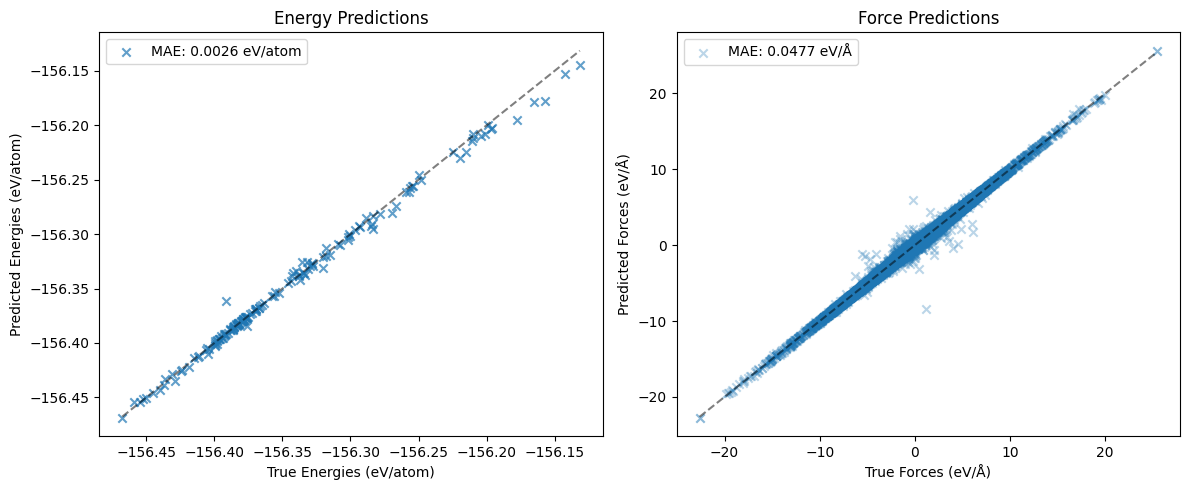

In [ ]:
# SOLUTION CELL
fig, ax = plt.subplots(1, 2, figsize=(12, 5))


# Helper function to compute Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))


# Energy correlation plot (normalized per atom)
atoms = np.array([len(frame) for frame in test_frames])
true_energies_norm = np.array(true_energies) / atoms
pred_energies_norm = np.array(pred_energies) / atoms
e_mae = mae(true_energies_norm, pred_energies_norm)

ax[0].scatter(
    true_energies_norm,
    pred_energies_norm,
    marker="x",
    alpha=0.7,
    label=f"MAE: {e_mae:.4f} eV/atom",
)
ax[0].plot(
    [true_energies_norm.min(), true_energies_norm.max()],
    [true_energies_norm.min(), true_energies_norm.max()],
    "k--",
    alpha=0.5,
)
ax[0].set_xlabel("True Energies / eV/atom")
ax[0].set_ylabel("Predicted Energies / eV/atom")
ax[0].set_title("Energy Predictions")
ax[0].legend()

# Force correlation plot
true_forces_flat = np.concatenate([f.flatten() for f in true_forces])
pred_forces_flat = np.concatenate([f.flatten() for f in pred_forces])
f_mae = mae(true_forces_flat, pred_forces_flat)

ax[1].scatter(
    true_forces_flat,
    pred_forces_flat,
    marker="x",
    alpha=0.3,
    label=f"MAE: {f_mae:.4f} eV/Å",
)
ax[1].plot(
    [true_forces_flat.min(), true_forces_flat.max()],
    [true_forces_flat.min(), true_forces_flat.max()],
    "k--",
    alpha=0.5,
)
ax[1].set_xlabel(r"True Forces / eV/Å")
ax[1].set_ylabel(r"Predicted Forces / eV/Å")
ax[1].set_title("Force Predictions")
ax[1].legend()

plt.tight_layout()
plt.show()

### Exercise 2: Comparative Model Analysis

Now that you've analyzed the performance of the `r_max_5_5_Apax` model, compute energy and force MAEs for all available models.

**Questions to consider:**
- Which hyperparameters have the strongest impact on accuracy?
- Is there a trade-off between accuracy and computational speed?
- How do different parameters affect energy vs. force predictions?

In [ ]:
# SOLUTION CELL
model_names = [
    "nn_16-16_Apax",
    "nn_32-32_Apax",
    "nn_64-64_Apax",
    "nn_128-128_Apax",  # NN variations
    "r_max_2_Apax",
    "r_max_3_Apax",
    "r_max_4_Apax",
    "r_max_5_Apax",
    "r_max_5_5_Apax",
    "r_max_6_Apax",  # Cutoff variations
    "n_basis_4_Apax",
    "n_basis_8_Apax",
    "n_basis_16_Apax",  # Basis function variations
    "n_radial_5_Apax",
    "n_radial_6_Apax",
    "n_radial_7_Apax",  # Radial resolution variations
]


def mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))


atoms = np.array([len(frame) for frame in test_frames])
results = {}

# Progress bar for model evaluation
pbar = tqdm(model_names, desc="Evaluating models")

for name in pbar:
    pbar.set_description(f"Evaluating {name}")

    # Load model and get calculator
    model = zntrack.from_rev(name)
    calc = model.get_calculator()

    # Measure evaluation time
    start = datetime.datetime.now()
    pred_frames = calc.batch_eval(test_frames, batch_size=1, silent=True)
    end = datetime.datetime.now()

    # Extract predictions and compute metrics
    pred_energies = [x.get_potential_energy() for x in pred_frames]
    pred_forces = [x.get_forces() for x in pred_frames]

    # Calculate normalized energy MAE and force MAE
    pred_energies_norm = np.array(pred_energies) / atoms
    e_mae = mae(true_energies_norm, pred_energies_norm)

    pred_forces_flat = np.concatenate([f.flatten() for f in pred_forces])
    f_mae = mae(true_forces_flat, pred_forces_flat)

    # Store results
    results[name] = (e_mae, f_mae, end - start)

# Display results in a formatted table
print("Model Performance Comparison")
print("=" * 70)
print(f"{'Model':<20} {'Energy MAE':<15} {'Force MAE':<15} {'Time / s':<10}")
print(f"{'':20} {'/ eV/atom':<15} {'/ eV/Å':<15} {'':10}")
print("-" * 70)

for name, (e_mae, f_mae, duration) in results.items():
    print(f"{name:<20} {e_mae:<15.4f} {f_mae:<15.4f} {duration.total_seconds():<10.2f}")

print("\nKey Observations:")
print("- Lower MAE values indicate better accuracy")
print("- Time reflects computational cost per evaluation")
print("- Best models balance accuracy and efficiency")

Evaluating models:   0%|          | 0/16 [00:00<?, ?it/s]

/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages/zntrack/state.py:159: UserWarning: The temporary path is not used when neither remote or rev are set.Consider checking for `self.state.remote` and `self.state.rev` whenusing `with node.state.use_tmp_path(): ...` .
  warnings.warn(
/work/fzills/projects/2025-espresso-water/.venv/lib/python3.11/site-packages

Model Performance Comparison
Model                Energy MAE      Force MAE       Time (s)  
                     (eV/atom)       (eV/Å)                    
----------------------------------------------------------------------
nn_16-16_Apax        0.0034          0.0485          4.66      
nn_32-32_Apax        0.0026          0.0458          4.81      
nn_64-64_Apax        0.0029          0.0503          4.95      
nn_128-128_Apax      0.0029          0.0474          4.87      
r_max_2_Apax         0.0479          0.3596          4.19      
r_max_3_Apax         0.0040          0.0919          4.27      
r_max_4_Apax         0.0031          0.0610          4.50      
r_max_5_Apax         0.0028          0.0483          4.66      
r_max_5_5_Apax       0.0026          0.0477          4.85      
r_max_6_Apax         0.0028          0.0440          5.07      
n_basis_4_Apax       0.0045          0.0543          4.63      
n_basis_8_Apax       0.0028          0.0477          4.73      
n_ba

# System Setup for Molecular Dynamics

MLIPs differ fundamentally from classical force fields in their setup requirements.
Classical force fields require explicit molecular topologies to assign parameters for inter- and intramolecular interactions.
MLIPs, however, learn these interactions directly from training data and only require:
- Atomic species (element types)
- Atomic positions
- Unit cell vectors (for periodic systems)

While this simplicity is powerful, creating atomic coordinates manually is impractical for most systems.
Therefore, we use higher-level representations and automated tools:

## SMILES Representation
We use SMILES (Simplified Molecular-Input Line-Entry System) <a href='#[6]'>[6]</a> strings to describe molecular structures.
For water, the SMILES string is simply `O` (representing the oxygen atom with implicit hydrogens).
The [rdkit2ase](https://zincware.github.io/rdkit2ase/) package provides convenient functions to convert SMILES strings into 3D atomic coordinates.

Generated water molecule as ASE Atoms object: Atoms(symbols='OH2', pbc=False)
Chemical species: ['O', 'H', 'H']
Atomic positions (Å):
[[-0.00570308  0.38515871 -0.        ]
 [-0.79607794 -0.194675   -0.        ]
 [ 0.80178102 -0.1904837   0.        ]]


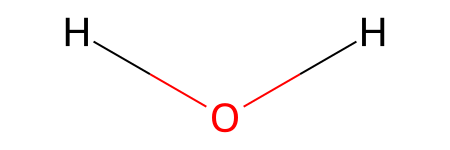

In [ ]:
# Generate water molecule conformations from SMILES
water = rdkit2ase.smiles2conformers("O", numConfs=100)

print(f"Generated water molecule as ASE Atoms object: {water[0]}")
print(f"Chemical species: {water[0].get_chemical_symbols()}")
print(f"Atomic positions / Å:\n{water[0].get_positions()}")

# Visualize the molecular structure using RDKit
rdkit2ase.ase2rdkit(water[0])

## Creating Bulk Systems with PACKMOL

To create a realistic liquid water system for MD simulation, we need to pack multiple water molecules into a periodic box at the appropriate density.
We use the PACKMOL software package for this purpose, which efficiently packs molecules while avoiding unrealistic overlaps.

In [28]:
# Create a liquid water box using PACKMOL
# Parameters: 100 water molecules at liquid density (997 kg/m³)
box = rdkit2ase.pack(
    [water],  # List of molecules to pack
    counts=[100],  # Number of each molecule type
    density=997,  # Density in kg/m³
    packmol="/data/fzills/tools/packmol-20.15.1/packmol",  # Path to PACKMOL executable
)

For our MLIP, this system is represented as:
- 300 atoms (100 × 3 atoms per water molecule)
- XYZ coordinates in 3D space
- Periodic boundary conditions defined by cell vectors
- Atomic species labels (O and H)

No explicit bonds, angles, or other topological information is needed – the MLIP learned these interactions from its training data.

In [29]:
# Assign the MLIP calculator to our water box
box.calc = calc

In [30]:
# Compute the potential energy of the entire system
energy = box.get_potential_energy() * ureg.eV
print(f"Potential energy of the water box: {energy:.2f~P}")

Potential energy of the water box: -46866.79 eV


In [31]:
# Compute forces on all atoms
forces = box.get_forces() * ureg.eV / ureg.angstrom
print(f"Forces on atoms (first 5 shown): {forces[:5]:.2f~P}")

Forces on atoms (first 5 shown): [[-0.03 0.75 -0.22] [1.49 0.88 0.37] [-2.01 -0.34 0.23] [0.08 -0.32 1.25] [-0.36 1.13 -0.14]] eV/Å


## Uncertainty Quantification with Ensemble Methods

One feature of the APAX MLIP framework is its ability to estimate the uncertainty of its predictions using ensemble methods.
Our models use a "shallow ensemble" approach where the final layers of the neural network are replicated with different random initializations:

```yaml
ensemble:
    kind: shallow
    n_members: 16
```

This configuration creates 16 different "members" in the ensemble. The final prediction is the mean across all ensemble members, and the standard deviation provides an estimate of prediction uncertainty.

**Applications of uncertainty quantification:**
- Monitor prediction reliability during MD simulations
- Stop simulations automatically when uncertainty exceeds thresholds
- Identify regions of configuration space poorly covered by training data
- Guide active learning strategies for model improvement

This capability is particularly valuable for long MD simulations where the system may explore configurations far from the training distribution.

In [32]:
# Examine available results from the calculator
print("Available calculator results:")
print(list(box.calc.results.keys()))

Available calculator results:
['energy', 'energy_ensemble', 'energy_uncertainty', 'forces', 'forces_ensemble', 'forces_uncertainty']


In [ ]:
# Extract and display prediction uncertainty
energy_uncertainty = box.calc.results["energy_uncertainty"] * ureg.eV
print(f"Energy prediction: {energy:.1f~P} ± {energy_uncertainty:.1f~P}")

Energy prediction: -46866.8 eV ± 7.3 eV
Relative uncertainty: 0.02 dimensionless%


## Preparing for ESPResSo Integration

With our water system configured and the MLIP calculator assigned, we're ready to integrate with ESPResSo for molecular dynamics simulations.
The ASE calculator interface provides a seamless bridge between our APAX models and ESPResSo's simulation engine.

In [34]:
# Save the water system for use in ESPResSo simulations
from ase.io import write

write("water.xyz", box)
print("Water system saved to water.xyz for ESPResSo integration")

Water system saved to water.xyz for ESPResSo integration


## Key Learning Outcomes

By completing this tutorial, you have learned:

1. **MLIP Fundamentals**: How machine-learned interatomic potentials differ from classical force fields and their advantages for complex chemical systems
2. **Model Evaluation**: Methods to assess MLIP accuracy using correlation plots and error metrics
3. **Hyperparameter Effects**: How different model parameters (cutoff radius, neural network size, basis functions) affect accuracy and computational cost
4. **System Preparation**: Creating realistic molecular systems using SMILES representations and PACKMOL
5. **Uncertainty Quantification**: Using ensemble methods to estimate prediction reliability
6. **Integration Workflow**: Connecting APAX models with simulation engines through ASE calculators

## Next Steps

This tutorial provides the foundation for using MLIPs in ESPResSo simulations. Consider exploring:
- Longer MD simulations to study dynamic properties
- Temperature and pressure effects on model performance  
- Active learning strategies for model improvement
- Comparison with other MLIP frameworks (MACE, NequIP, etc.)

---

## References

<a id='[1]'></a>[1] Moritz R. Schäfer, Nico Segreto, Fabian Zills, Christian Holm, and Johannes Kästner. <a href="https://doi.org/10.1021/acs.jcim.5c01221">Apax: A Flexible and Performant Framework for the Development of Machine-Learned Interatomic Potentials</a>. *Journal of Chemical Information and Modeling* 2025 65 (15), 8066-8078

<a id='[2]'></a>[2] Fabian Zills, Moritz René Schäfer, Nico Segreto, Johannes Kästner, Christian Holm, and Samuel Tovey. <a href="https://doi.org/10.1021/acs.jpcb.3c07187">Collaboration on Machine-Learned Potentials with IPSuite: A Modular Framework for Learning-on-the-Fly</a>. *The Journal of Physical Chemistry B* 2024 128 (15), 3662-3676

<a id='[3]'></a>[3] B. Cheng, E.A. Engel, J. Behler, C. Dellago, & M. Ceriotti. <a href="https://doi.org/10.1073/pnas.1815117116">Ab initio thermodynamics of liquid and solid water</a>. *Proc. Natl. Acad. Sci. U.S.A.* 2019 116 (4) 1110-1115

<a id='[4]'></a>[4] Ask Hjorth Larsen et al. <a href="https://iopscience.iop.org/article/10.1088/1361-648X/aa680e">The atomic simulation environment—a Python library for working with atoms</a>. *J. Phys.: Condens. Matter* 2017 29 273002

<a id='[5]'></a>[5] Fabian Zills, Moritz Schäfer, Samuel Tovey, Johannes Kästner, Christian Holm. <a href="https://doi.org/10.48550/arXiv.2401.10603">ZnTrack -- Data as Code</a>. *arXiv:2401.10603 [cs.MS]* 2024

<a id='[6]'></a>[6] David Weininger. <a href="https://pubs.acs.org/doi/10.1021/ci00057a005">SMILES, a chemical language and information system. 1. Introduction to methodology and encoding rules</a>. *Journal of Chemical Information and Computer Sciences* 1988, 28 (1), 31–36